## Setup

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu" # only use CPU in this notebook

In [2]:
from functools import partial
import numpy as np
from typing import Callable

import blackjax
import h5py
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import stats
import matplotlib.pyplot as plt
from jax import jit as jjit
from jax import random, vmap
from jax import random
from tqdm import tqdm

from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from bpd.io import save_dataset_h5py, load_dataset_h5py
from bpd.diagnostics import get_contour_plot
from bpd.chains import inference_loop

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_cpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from bpd.likelihood import shear_loglikelihood, shear_loglikelihood_unreduced
from bpd.prior import ellip_mag_prior, sample_ellip_prior, sample_synthetic_sheared_ellips_unclipped

In [4]:
jax.config.update("jax_enable_x64", True)
jax.devices()

[CpuDevice(id=0)]

In [5]:
def log_target(e_sheared, e_obs, sigma_m, interim_prior: Callable = None):
    assert e_sheared.shape == (2,) and e_obs.shape == (2,)

    # ignore angle because flat
    # prior enforces magnitude < 1.0 for posterior samples
    e_sheared_mag = jnp.sqrt(e_sheared[0] ** 2 + e_sheared[1] ** 2)
    prior = jnp.log(interim_prior(e_sheared_mag))

    likelihood = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return prior + likelihood

def do_inference_random(rng_key, init_positions, e_obs, sigma_m, sigma_e, cov_matrix=jnp.eye(2), m=100):
    interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
    _logtarget = partial(
        log_target, e_obs=e_obs, sigma_m=sigma_m, interim_prior=interim_prior
    )

    rw_gaussian = blackjax.additive_step_random_walk.normal_random_walk(_logtarget, cov_matrix)
    state = rw_gaussian.init(init_positions)
    kernel = rw_gaussian.step
    states, _ = inference_loop(rng_key, state, kernel=kernel, n_samples=m)
    return states.position
    
    
    # new_state, info = rw_gaussian.step(rng_key, state)


# def do_inference(rng_key, init_positions, e_obs, sigma_m, sigma_e, m=10):
#     interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
#     _logtarget = partial(
#         log_target, e_obs=e_obs, sigma_m=sigma_m, interim_prior=interim_prior
#     )

#     key1, key2 = random.split(rng_key)

#     warmup = blackjax.window_adaptation(
#         blackjax.nuts,
#         _logtarget,
#         progress_bar=False,
#         is_mass_matrix_diagonal=True,
#         max_num_doublings=5,
#         initial_step_size=0.01,
#         target_acceptance_rate=0.80,
#     )

#     (init_states, tuned_params), _ = warmup.run(key1, init_positions, 500)
#     kernel = blackjax.nuts(_logtarget, **tuned_params).step
#     states, _ = inference_loop(key2, init_states, kernel=kernel, n_samples=m)
#     return states.position

# Interim posteriors

In [6]:
key = random.key(42)
k1, k2, k3 = random.split(key, 3)

true_g = 0.02, 0.00
n_gals = int(1e5)

sigma_e = 1e-2
sigma_m = 1e-3

In [7]:
# get samples
e_obs, e_sheared, _ = sample_synthetic_sheared_ellips_unclipped(
k1, true_g, n=n_gals, sigma_m=sigma_m, sigma_e=sigma_e
)
e_obs.shape

(100000, 2)

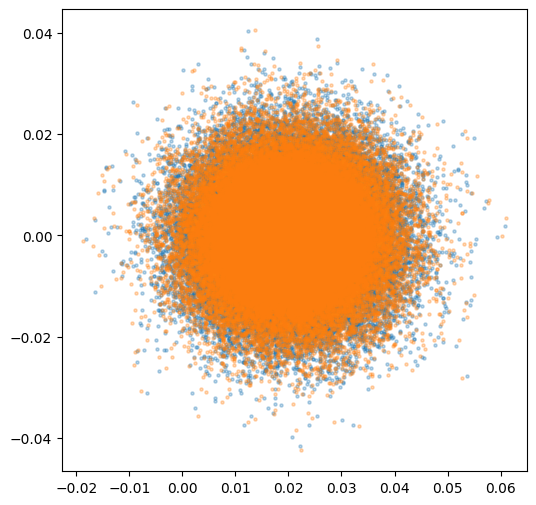

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(e_obs[:, 0], e_obs[:, 1], s=5, alpha=0.3)
plt.scatter(e_sheared[:, 0], e_sheared[:, 1], s=5, alpha=0.3)

## For a couple of ellipticities, determine efficiency

In [9]:
cov = jnp.eye(2) * 1e-3 # seems roughly good

In [133]:
_do_inference = jax.jit(partial(do_inference_random, sigma_e=sigma_e, sigma_m=sigma_m, m=1000, cov_matrix=cov))
_do_inference_vmap = jax.vmap(_do_inference, in_axes=(0, None, None)) # different keys, same chain 
_do_inference_batched = jax.vmap(_do_inference_vmap, in_axes=(0, 0, 0))

In [134]:
n_chains_per_gal = 4
n_chains = 10
keys2 = random.split(k2, n_chains_per_gal * n_chains).reshape(n_chains, n_chains_per_gal)
keys2.shape

(10, 4)

In [135]:
e_post =_do_inference_batched(keys2, e_sheared[:n_chains], e_obs[:n_chains])
e_post.shape

(10, 4, 1000, 2)

In [136]:
effective_sample_size(e_post[3, :, :, 1], chain_axis=0, sample_axis=1), potential_scale_reduction(e_post[9, :, :, 1], chain_axis=0, sample_axis=1) # roughly suggest to trim by 3

(Array(428.29380794, dtype=float64), Array(1.00741228, dtype=float64))

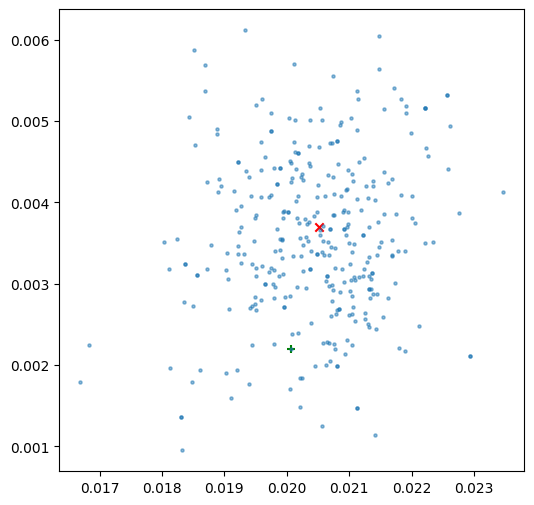

In [137]:
plt.figure(figsize=(6,6))

plt.scatter(e_obs[0, 0], e_obs[0, 1], color='r', marker='x')
plt.scatter(e_sheared[0, 0], e_sheared[0, 1], color='g', marker='+')

# plt.scatter(e_post[0, 0, :, 0], e_post[0, 0, :, 1], s=5, alpha=0.3)
plt.scatter(e_post[0, 0, ::3, 0], e_post[0, 0, ::3, 1], s=5, alpha=0.5)

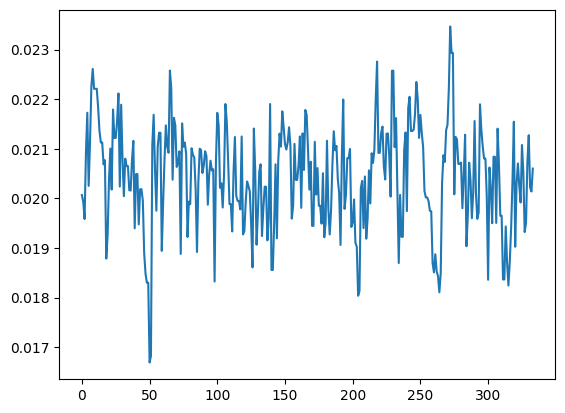

In [139]:
# plt.plot(e_post[0, 0, : ,0])
plt.plot(e_post[0, 0, ::3 ,0])

## Run chains to get interim posterior ellipticity

In [9]:
cov = jnp.eye(2) * 1e-3 # seems roughly good

In [10]:
keys2 = random.split(k2, n_gals)
keys2.shape

(100000,)

In [11]:
_do_inference = jax.jit(partial(do_inference_random, sigma_e=sigma_e, sigma_m=sigma_m, m=1000, cov_matrix=cov))
_do_inference_vmap = jax.vmap(_do_inference, in_axes=(0, 0, 0)) # different keys, same chain 


In [12]:
# compile 
_ = _do_inference_vmap(keys2[:1], e_sheared[:1], e_obs[:1])

In [13]:
e_post = _do_inference_vmap(keys2, e_sheared, e_obs)
e_post.shape

(100000, 1000, 2)

In [14]:
e_post_trim = e_post[:, ::5, :] # to be safe
e_post_trim.shape

(100000, 200, 2)

In [15]:
# plt.figure(figsize=(6,6))
# # plt.scatter(e_obs[:, 0], e_obs[:, 1], s=5, alpha=0.3)
# # plt.scatter(e_sheared[:, 0], e_sheared[:, 1], s=5, alpha=0.3)
# # plt.scatter(e_post[:, 0, 0], e_post[:, 0, 1], s=5, alpha=0.3)

# Shear chain efficiency (1 chain)

In [16]:
prior = partial(ellip_mag_prior, sigma=sigma_e)
interim_prior = partial(ellip_mag_prior, sigma=sigma_e * 2)
_loglikelihood_fnc = partial(shear_loglikelihood, prior=prior, interim_prior=interim_prior)

def logtarget_density2(g, e_post):
    loglike = _loglikelihood_fnc(g, e_post)
    logprior = stats.uniform.logpdf(g, -0.1, 0.2).sum()
    return logprior + loglike

def do_inference_random2(rng_key, init_g, logtarget, cov_matrix=jnp.eye(2), n_samples=1000):
    rw_gaussian = blackjax.additive_step_random_walk.normal_random_walk(logtarget, cov_matrix)
    state = rw_gaussian.init(init_g)
    kernel = rw_gaussian.step
    states, _ = inference_loop(rng_key, state, kernel=kernel, n_samples=n_samples)
    return states.position

In [17]:
cov = jnp.eye(2) * 4e-5 # seems reasonable
init_g = jnp.array(true_g)  

In [ ]:
_logtarget = partial(logtarget_density2, e_post=e_post_trim)
# _logtarget(init_g) # compile

2024-09-26 14:22:38.521513: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.164 = f64[100000,200,1]{2,1,0} slice(f64[100000,200,2]{2,1,0} %constant.28), slice={[0:100000], [0:200], [0:1]}, metadata={op_name="jit(<unnamed wrapped function>)/jit(main)/slice" source_file="/global/u2/i/imendoza/BPD/bpd/prior.py" source_line=88}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


In [19]:
_do_inference2 = partial(do_inference_random2, logtarget=_logtarget, cov_matrix=cov, n_samples=100)
# _do_inference2_vmap = jax.vmap(_do_inference2, in_axes=(0, None))

In [20]:
# keys3 = random.split(k3, 4) # check efficiency and rhat

In [21]:
# g_samples = _do_inference2(k3, init_g)
# g_samples.shape

In [23]:
g_samples1 = _do_inference2(k3, init_g)
g_samples1.shape

(100, 2)

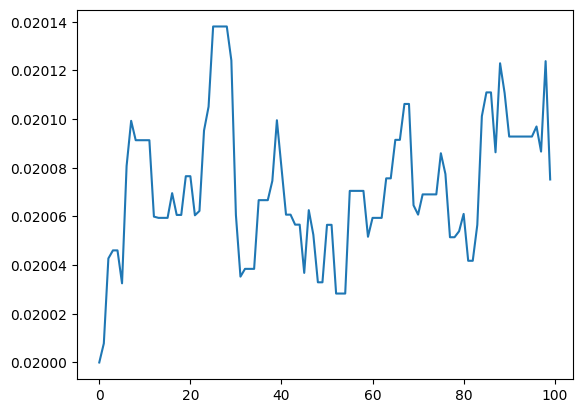

In [25]:
plt.plot(g_samples1[:, 0])


In [22]:
g_samples = _do_inference2_vmap(keys3, init_g)
g_samples.shape

(4, 100, 2)

In [78]:
ess1 = effective_sample_size(g_samples[:, :, 0], chain_axis=0, sample_axis=1)
ess2 = effective_sample_size(g_samples[:, :, 1], chain_axis=0, sample_axis=1)
rhat1 = potential_scale_reduction(g_samples[:, :, 0], chain_axis=0, sample_axis=1)
rhat2 = potential_scale_reduction(g_samples[:, :, 1], chain_axis=0, sample_axis=1)
ess1, ess2, rhat1, rhat2

(Array(8.10306431, dtype=float64),
 Array(14.79494064, dtype=float64),
 Array(1.22158328, dtype=float64),
 Array(1.14357978, dtype=float64))

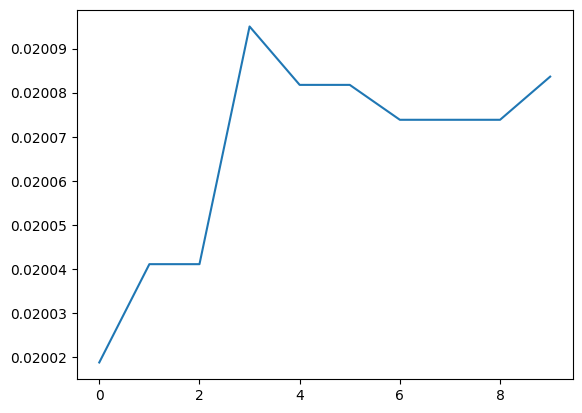

In [85]:
plt.plot(g_samples[0, :, 0])
